In [14]:
import serial
import numpy as np
import matplotlib.pyplot as plt
import os
import pyvisa as visa
from pathlib import Path
from scipy.interpolate import interp1d

from saveCalData import saveMeasurement

In [16]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [17]:
## How to make use of update_progress()
number_of_elements = 1000

for i in range(number_of_elements):
    time.sleep(0.1) #Replace this with a real computation
    update_progress(i / number_of_elements)

update_progress(1)

Progress: [##------------------] 10.3%


KeyboardInterrupt: 

In [2]:
def serialQry(port, command):
    port.reset_input_buffer()
    port.write((command + '\n').encode('ascii'))
    return port.readline().decode('ascii').strip() #strip removes white space

def serialCmd(port, command):
    port.reset_input_buffer()
    port.write((command + '\n').encode('ascii'))

In [61]:
def rms(x):
    return np.sqrt(np.mean(x**2))

In [3]:
sr542 = serial.Serial(port='COM11', baudrate=115200, timeout=.5)
cs580 = serial.Serial(port='COM10', baudrate=9600, timeout=0.5)
rm = visa.ResourceManager()
rm.list_resources()
dvm = rm.open_resource('USB0::0x0957::0xB318::MY52449038::INSTR')

('USB0::0x0957::0xB318::MY52449038::INSTR',
 'TCPIP0::K-000000-00000::hislip0::INSTR',
 'TCPIP0::K-000000-00000::inst0::INSTR',
 'ASRL1::INSTR',
 'ASRL3::INSTR',
 'ASRL10::INSTR',
 'ASRL11::INSTR')

In [6]:
print(serialQry(sr542, '*IDN?'))
print(serialQry(cs580, '*IDN?'))
print(dvm.query('*IDN?'))

Stanford_Research_Systems, SR542, s/n00001007, v0.10
Stanford_Research_Systems,CS580,s/n137132,ver1.14
Agilent Technologies,34450A,MY52449038,00.56-00.63



# Define Cal Functions

In [131]:
def SweepI_MeasV(I_init, I_final, I_step):

    I_sweep = np.arange(I_init, I_final + I_step, I_step)

    serialCmd(cs580, 'GAIN G50mA')
    serialCmd(cs580, f'CURR {I_init:.3f}')
    serialCmd(cs580, 'INPT OFF')
    serialCmd(cs580, 'SOUT ON')

    time.sleep(1.0)
    V_meas = []

    for curr in I_sweep:
        serialCmd(cs580, f'CURR {curr:.3f}')
        time.sleep(1.0)
        V_meas.append(float(dvm.query('MEAS:VOLT:DC? 0.1, 3e-5').strip('\n')))
        
    serialCmd(cs580, 'CURR 0')
    serialCmd(cs580, 'SOUT OFF')
    
    coeffs, cov = np.polyfit(I_sweep, V_meas, 1, cov=True)
    fit = np.poly1d(coeffs)
    R_meas = coeffs[0]
    R_std = np.sqrt(np.diag(cov))[0]
    print(f'R = {R_meas:.5e} +- {R_std:.5e} Ohms')
    
    plt.plot(I_sweep, V_meas, '.')
    plt.plot(I_sweep, fit(I_sweep), label=f'fit: R={coeffs[0]:.6} Ohms')
    plt.xlabel('applied current (A)')
    plt.ylabel('meas voltage (V)')
    plt.legend()

    return (R_meas, R_std)

def MeasCurrVsDacCode(codes, channel='U'):
    serialCmd(sr542, '$CEN ON')
    time.sleep(1.0)
    
    t0 = time.time()
    
    V_sense = []
    for dacCode in codes:
        if(channel=='U'):
            serialCmd(sr542, f'$SUV {dacCode}, 2048')
        elif(channel=='V'):
            serialCmd(sr542, f'$SUV 2048, {dacCode}')
        else:
            print('Invalid Channel')
            break
            
        time.sleep(0.1) #TODO: how long to sleep here?
        V = float(dvm.query('MEAS:VOLT:DC? 10, 1.5e-6')) #voltage measured across ~R_sense
        #print(f'{dacCode}, {V}')
        V_sense.append(V) 
        
        update_progress(len(V_sense) / len(codes))

    serialCmd(sr542, '$SUV 2048, 2048')
    serialCmd(sr542, '$CEN OFF')
    
    print(f'elapsed time = {time.time() - t0}')
    
    return np.array(V_sense)

def PlotCurrentError(codes, V_meas, R_meas):    
    def CurrentToLsb(I_A):
        return I_A/LSB_A

    def LsbToCurrent(bits):
        return bits*LSB_A
    
    I_A = V_meas/R_meas
    I_A_error = I_A - idealCurrent(codes)
    I_c_error = I_A_error/LSB_A
    
    minor_ticks = np.arange(int(min(I_c_error)), int(max(I_c_error)), 1)

    fig, axL = plt.subplots()
    axL.plot(codes, I_c_error, '.')
    axL.set_xlabel('dac code')
    axL.set_ylabel('output error (LSBs)')    
    axL.set_yticks(minor_ticks, minor=True)
    axL.grid('y')
    axL.grid('y', which='minor', alpha=0.5)

    axR = axL.secondary_yaxis('right', functions=(LsbToCurrent, CurrentToLsb))
    axR.grid(axis='y')
    axR.set_ylabel('output error (A)')

## Perform the Measurements

R = 9.92111e-02 +- 1.90469e-05 Ohms


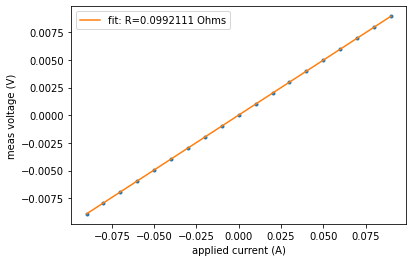

In [45]:
R_U_ohms, R_U_ohms_std = SweepI_MeasV(-90e-3, 90e-3, 10e-3)

R = 9.92669e-02 +- 1.57013e-05 Ohms


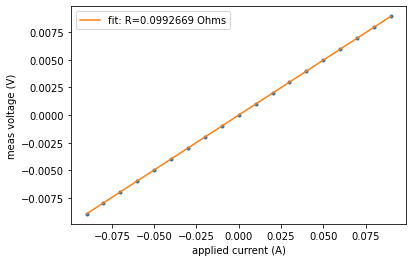

In [9]:
R_V_ohms, R_V_ohms_std = SweepI_MeasV(-90e-3, 90e-3, 10e-3)

In [75]:
# Calibrated resistances determined from 4-pt IV's
#Resistors on PN x-20180205 Amplifier Prototype, SN 1
#R_U_ohms = 1.9864
#R_V_ohms = 2.0028
#R_W_ohms = 2.0030

# SR549 100
R_U_ohms = 9.92309114e-02
R_V_ohms = 9.94547231e-02
R_W_ohms = 1e-1 # nominal resistance

In [80]:
# Globals. Is this the best way to do this?
Vref = 3.3
dacBits = 12
numCodes = 2**dacBits
R_f = 10e3
R_in = 90.9e3
R_sense_nom = 0.1
HowlandGain = R_f/(R_in*R_sense_nom)
LSB_A = Vref/numCodes*HowlandGain
idealCurrent = np.poly1d([Vref/numCodes, -Vref/2])*HowlandGain
allCodes = np.linspace(0, numCodes-1, numCodes, dtype=int)

## Run the initial uncal'd measurement

In [12]:
# Define the measurement sweep
testCodes = np.linspace(0, numCodes-1, 400, dtype=int)

In [15]:
# Do the initial current sweep
V_U = MeasCurrVsDacCode(testCodes, channel='U')

elapsed time = 850.485102891922


In [73]:
V_V_fast = V_V

In [77]:
V_V_slow = MeasCurrVsDacCode(testCodes, channel='V')

Progress: [####################] 100.0%
elapsed time = 849.521271944046


Text(0.5, 1.0, "Channel U - Uncal'd Output")

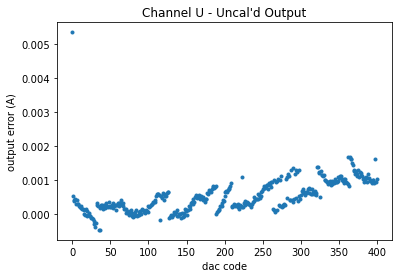

In [16]:
plt.plot(V_U/R_U_ohms - idealCurrent(testCodes), '.')
plt.xlabel('dac code')
plt.ylabel('output error (A)')
plt.title("Channel U - Uncal'd Output")

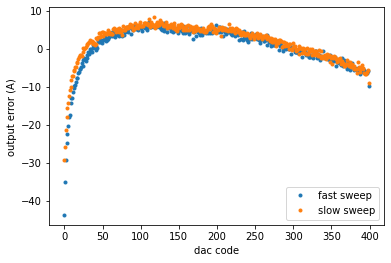

In [81]:
plt.plot((V_V_fast/R_V_ohms - idealCurrent(testCodes))/LSB_A, '.')
plt.plot((V_V_slow/R_V_ohms - idealCurrent(testCodes))/LSB_A, '.')
plt.xlabel('dac code')
plt.ylabel('output error (A)')
plt.legend(('fast sweep', 'slow sweep'))

## Do a linear fit correction to the measurent current

To convert a desired setpoint code $c_i$ to a corrected code  $c_c$
\begin{equation}
c_c = \frac{m_i}{m_m} c_i + \frac{(b_i - b_m)}{m_m}
\end{equation}

Where the ideal output is given by
\begin{equation}
I_i = m_i c_i + b_i
\end{equation}

And the measured output is given by
\begin{equation}
I_m = m_m c_m + b_m
\end{equation}

Where $I$ is measured in Amps, $c$ is dac code, $m$ is Amps/code and $b$ is an offset in Amps

The ideal values are given by:

`m_i = 3.3/4096`  
`b_i = -3.3/2`

And $m_m$ and $b_m$ are determined by a linear fit to the measured output current

Simplifying:
\begin{equation}
c_c = m c_i + b
\end{equation}
where $m = m_i/m_m$ and $b = (b_i - b_m)/m_m$

In [65]:
def SlopeAndOffsetCorrections(codes, curr):
    coeffs = np.polyfit(codes, curr, 1)
    
    # ideal slope, offset
    m_i = 3.3/4096*HowlandGain
    b_i = -3.3/2*HowlandGain

    # actual slope, offset
    m = m_i/coeffs[0]
    b = (b_i - coeffs[1])/coeffs[0]

    return m, b    

def correctedCode(m, b, code):
    # Coerce slope+offset-corrected code to the range [0, 2**dacBits - 1]
    return np.clip(np.rint(m*code + b).astype('int16'), 0, 2**dacBits - 1)

## Create a LUT to correct the current output
1. Do a cubic spline fit to the measured output current vs. dac code
2. Calculate the error in the measured output current as (spline fit) - (ideal current)
3. Convert the error to a correction (with units of dac code)
4. Create the LUT as (commanded output - correction) [in units of dac code]

In [108]:
def CreateLUT(dacCodes, measCurrent):
    cubicSpline = interp1d(dacCodes, measCurrent, kind='cubic')
    
    #Vref = 3.3
    #dacBits = 12
    #numCodes = 2**dacBits
    #LSB_A = Vref/numCodes
    #idealCurrent = np.poly1d([Vref/numCodes, -Vref/2])
    
    allCodes = np.linspace(0, numCodes-1, numCodes, dtype=int)
    error_A = cubicSpline(allCodes) - idealCurrent(allCodes)
    error_c = error_A/LSB_A # error in number of LSBs (or codes)
    #plt.plot(allCodes, error_c)
    #plt.xlabel('dac code')
    #plt.ylabel('error (dac code)')
    
    LUT = np.rint(np.clip(allCodes - error_c, 0, 4095)).astype(np.int16)    
    
    return error_c, LUT, cubicSpline(allCodes)

def ApplyLUTCorrection(LUT, outputTxFun):
    plt.figure(figsize=(8,8))
    
    plt.plot(allCodes, (outputTxFun[allCodes] - idealCurrent(allCodes))/LSB_A, '.', label='uncal')
    plt.plot(allCodes, (outputTxFun[LUT[allCodes]] - idealCurrent(allCodes))/LSB_A, label='LUT correction')
    #plt.plot(allCodes, (currentOut_U[correctedCode(m_U, b_U, allCodes)] - idealCurrent(allCodes))/LSB_A, '.-', label='slope+offset correction')
    plt.grid(axis='y')
    plt.xlabel('dac code')
    plt.ylabel('output error (LSBs)')
    plt.legend()
    plt.title('Calibration Verification')

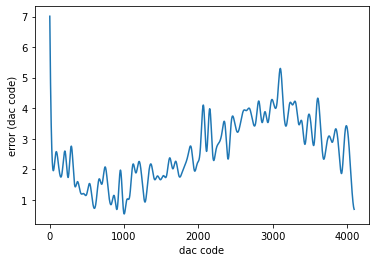

In [53]:
errorU, channelU_LUT = CreateLUT(codes, np.array(V_U)/R_U_ohms)

In [96]:
errorV, channelV_LUT, interpCurrOut_V = CreateLUT(testCodes, V_V/R_V_ohms)

In [97]:
errorV

array([-43.73414846, -42.67578293, -41.66421898, ...,  -8.37271902,
        -9.01945942,  -9.76414714])

In [98]:
channelV_LUT

array([  44,   44,   44, ..., 4095, 4095, 4095], dtype=int16)

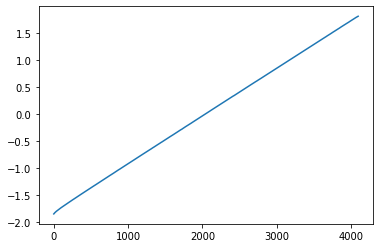

In [100]:
plt.plot(interpCurrOut_V)

In [36]:
# Convert the measured voltage to a LUT for current output
def OutputCurrentVsDacCodeLUT(dacCodes, measCurrent):
    cubicSpline = interp1d(dacCodes, measCurrent, kind='cubic')    
       
    allCodes = np.linspace(0, numCodes-1, numCodes, dtype=int)
    return cubicSpline(allCodes)

In [37]:
currentOut_V = OutputCurrentVsDacCodeLUT(testCodes, V_V/R_V_ohms)

Text(0.5, 1.0, 'Channel V')

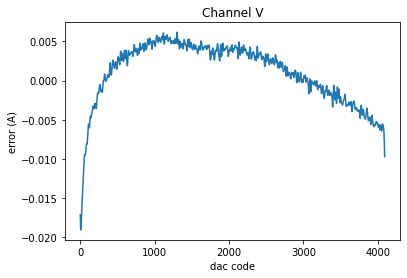

In [41]:
plt.plot(currentOut_V - idealCurrent(allCodes))
plt.xlabel('dac code')
plt.ylabel('error (A)')
plt.title('Channel V')

In [35]:
currentOut_U = OutputCurrentVsDacCodeLUT(testCodes, V_U/R_U_ohms)

Text(0.5, 1.0, 'Channel U')

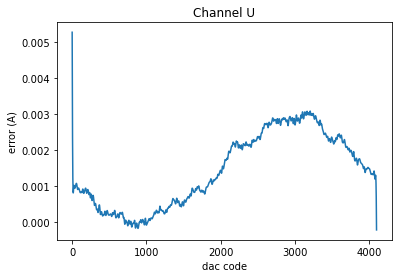

In [38]:
plt.plot(currentOut_U - idealCurrent(allCodes))
plt.xlabel('dac code')
plt.ylabel('error (A)')
plt.title('Channel U')

In [45]:
# CHANNEL U
# Do Slope/Offset Correction
m_U, b_U = SlopeAndOffsetCorrections(testCodes, V_U/R_U_ohms)
# Do LUT correction
errorU, channelU_LUT = CreateLUT(testCodes, V_U/R_U_ohms)

Text(0.5, 1.0, 'Channel U Calibration Verification')

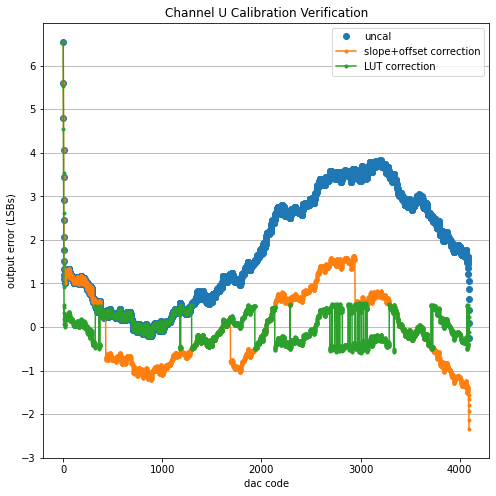

In [46]:
# Verify CHANNEL U
plt.figure(figsize=(8,8))
plt.plot(allCodes, (currentOut_U[allCodes] - idealCurrent(allCodes))/LSB_A, 'o', label='uncal')
plt.plot(allCodes, (currentOut_U[correctedCode(m_U, b_U, allCodes)] - idealCurrent(allCodes))/LSB_A, '.-', label='slope+offset correction')
plt.plot(allCodes, (currentOut_U[channelU_LUT[allCodes]] - idealCurrent(allCodes))/LSB_A, '.-', label='LUT correction')
plt.yticks(np.arange(-3, 7, 1))
plt.grid(axis='y')
plt.xlabel('dac code')
plt.ylabel('output error (LSBs)')
plt.legend()
plt.title('Channel U Calibration Verification')

In [53]:
# CHANNEL V
# Do Slope/Offset Correction
m_V, b_V = SlopeAndOffsetCorrections(testCodes, V_V/R_V_ohms)
# Do LUT correction
errorV, channelV_LUT = CreateLUT(testCodes, V_V/R_V_ohms)

Text(0.5, 1.0, 'Channel V Calibration Verification')

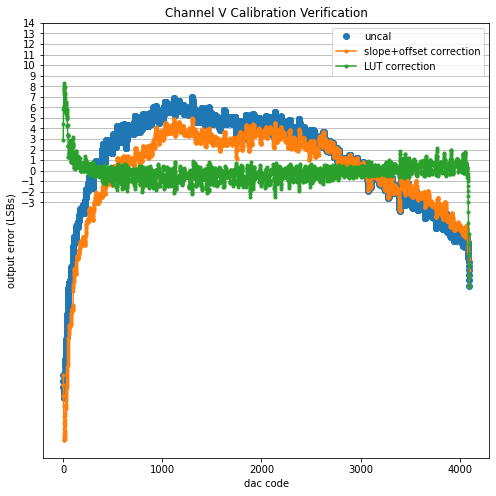

In [82]:
plt.figure(figsize=(8,8))
plt.plot(allCodes, (currentOut_V[allCodes] - idealCurrent(allCodes))/LSB_A, 'o', label='uncal')
plt.plot(allCodes, (currentOut_V[correctedCode(m_V, b_V, allCodes)] - idealCurrent(allCodes))/LSB_A, '.-', label='slope+offset correction')
plt.plot(allCodes, (currentOut_V[channelV_LUT[allCodes]] - idealCurrent(allCodes))/LSB_A, '.-', label='LUT correction')
plt.yticks(np.arange(-3, 15, 1))
plt.grid(axis='y')
plt.xlabel('dac code')
plt.ylabel('output error (LSBs)')
plt.legend()
plt.title('Channel V Calibration Verification')

Text(0.5, 1.0, 'Channel V Calibration Verification')

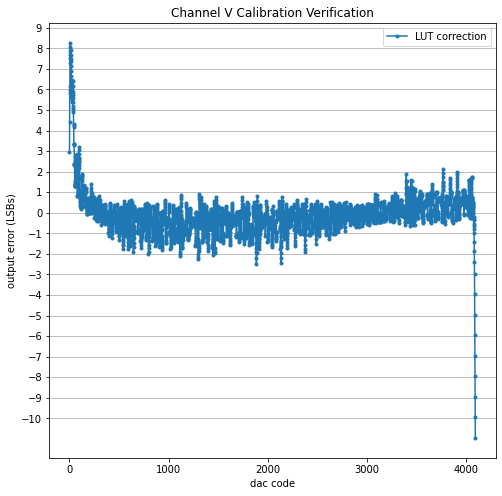

In [83]:
plt.figure(figsize=(8,8))
#plt.plot(allCodes, (currentOut_V[allCodes] - idealCurrent(allCodes))/LSB_A, 'o', label='uncal')
#plt.plot(allCodes, (currentOut_V[correctedCode(m_V, b_V, allCodes)] - idealCurrent(allCodes))/LSB_A, '.-', label='slope+offset correction')
plt.plot(allCodes, (currentOut_V[channelV_LUT[allCodes]] - idealCurrent(allCodes))/LSB_A, '.-', label='LUT correction')
plt.yticks(np.arange(-10, 10, 1))
plt.grid(axis='y')
plt.xlabel('dac code')
plt.ylabel('output error (LSBs)')
plt.legend()
plt.title('Channel V Calibration Verification')

# Experimental Verification of Calibration

In [56]:
# Define a new measurement sweep
verifyCodes = np.arange(3, numCodes-1, 20, dtype=int)

In [130]:
# CHANNEL U
# Verify each correction
V_U_so = MeasCurrVsDacCode(correctedCode(m_U, b_U, verifyCodes), channel='U')
V_U_LUT = MeasCurrVsDacCode(channelU_LUT[verifyCodes], channel='U')

In [57]:
# CHANNEL V
# Verify each correction
V_V_so = MeasCurrVsDacCode(correctedCode(m_V, b_V, verifyCodes), channel='V')
V_V_LUT = MeasCurrVsDacCode(channelV_LUT[verifyCodes], channel='V')

Progress: [####################] 100.0%
elapsed time = 435.60896849632263


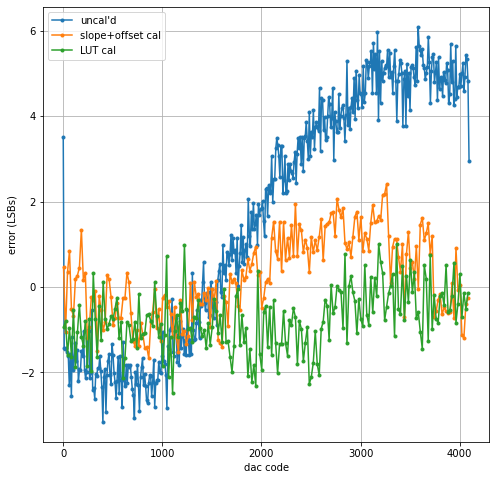

In [131]:
# CHANNEL U
fig, ax = plt.subplots(figsize=(8,8))
error_uncal = V_U/R_U_ohms - idealCurrent(testCodes)
error_so = V_U_so/R_U_ohms - idealCurrent(verifyCodes)
error_lut = V_U_LUT/R_U_ohms - idealCurrent(verifyCodes)

ax.plot(testCodes, error_uncal/LSB_A, marker='.', label="uncal'd")
ax.plot(verifyCodes, error_so/LSB_A, marker='.', label="slope+offset cal")
ax.plot(verifyCodes, error_lut/LSB_A, marker='.', label="LUT cal")
ax.legend()
ax.set_xlabel('dac code')
ax.set_ylabel('error (LSBs)')
ax.grid()

In [132]:
print(np.mean(V_U/R_U_ohms - idealCurrent(testCodes))/LSB_A)
print(np.mean(V_U_so/R_U_ohms - idealCurrent(verifyCodes))/LSB_A)
print(np.mean(V_U_LUT/R_U_ohms - idealCurrent(verifyCodes))/LSB_A)

1.6590671732049413
0.23216111207513507
-0.7675109516009432


In [133]:
print(rms(error_uncal/LSB_A))
print(rms(error_so/LSB_A))
print(rms(error_lut/LSB_A))

3.3232904617712458
0.9846952411612577
1.0484125652757255


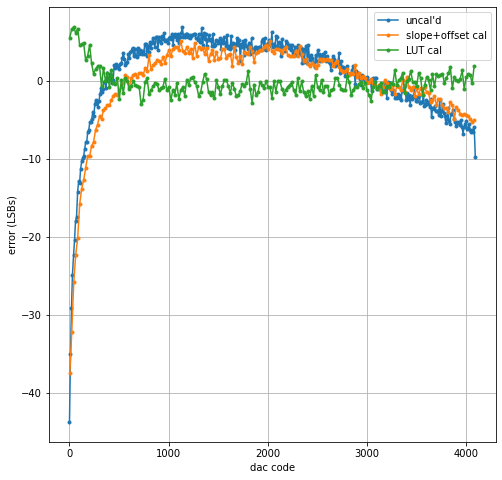

In [84]:
# CHANNEL V
fig, ax = plt.subplots(figsize=(8,8))
errorV_uncal = V_V/R_V_ohms - idealCurrent(testCodes)
errorV_so = V_V_so/R_V_ohms - idealCurrent(verifyCodes)
errorV_lut = V_V_LUT/R_V_ohms - idealCurrent(verifyCodes)

ax.plot(testCodes, errorV_uncal/LSB_A, marker='.', label="uncal'd")
ax.plot(verifyCodes, errorV_so/LSB_A, marker='.', label="slope+offset cal")
ax.plot(verifyCodes, errorV_lut/LSB_A, marker='.', label="LUT cal")
ax.legend()
ax.set_xlabel('dac code')
ax.set_ylabel('error (LSBs)')
ax.grid()

In [85]:
print(np.mean(errorV_uncal/LSB_A))
print(np.mean(errorV_so/LSB_A))
print(np.mean(errorV_lut/LSB_A))

0.7777454575168308
-0.16065543471649338
-0.16652360768658112


In [86]:
print(rms(errorV_uncal/LSB_A))
print(rms(errorV_so/LSB_A))
print(rms(errorV_lut/LSB_A))

5.8087068161699
5.739056188846242
1.6465993997884454


## Put it all together

Progress: [####################] 100.0%
elapsed time = 251.24395942687988


ValueError: operands could not be broadcast together with shapes (205,) (400,) 

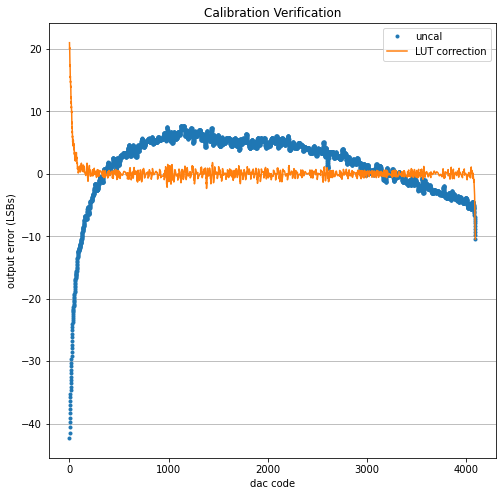

In [110]:
R_V_ohms, R_V_ohms_std = SweepI_MeasV(-90e-3, 90e-3, 10e-3)
testCodes = np.linspace(0, numCodes-1, 400, dtype=int)
V_V = MeasCurrVsDacCode(testCodes, channel='V')
PlotCurrentError(testCodes, V_V, R_V_ohms)
m_V, b_V = SlopeAndOffsetCorrections(testCodes, V_V/R_V_ohms)
errorV, channelV_LUT, interpCurrentOut_V = CreateLUT(testCodes, V_V/R_V_ohms)

# Predicted Corrected Output
ApplyLUTCorrection(channelV_LUT, interpCurrentOut_V)

# Experimental Verification
verifyCodes = np.arange(3, numCodes-1, 20, dtype=int)
V_V_LUT = MeasCurrVsDacCode(channelV_LUT[verifyCodes], channel='V')
PlotCurrentError(verifyCodes, V_V_LUT, R_V_ohms)

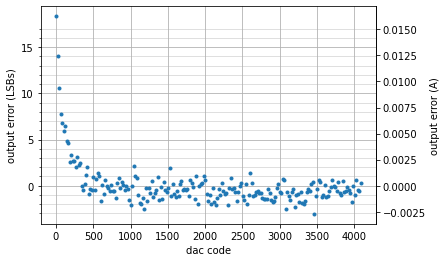

In [133]:
PlotCurrentError(verifyCodes, V_V_LUT, R_V_ohms)

In [61]:
controllerSn = serialQry(sr542, '*IDN?').split(',')[2].strip(' s/n')
controllerSn

'00000001'

In [62]:
np.savetxt(os.path.join('.\CalData', f'dacLUT_U_{controllerSn}_1.csv'), channelU_LUT[allCodes], newline='\n', fmt='%d', delimiter=',')


In [84]:
np.savetxt(os.path.join('.\CalData', f'dacLUT_V_{controllerSn}_1.csv'), channelV_LUT[allCodes], newline='\n', fmt='%d', delimiter=',')


## Upload LUTs to SR542

In [64]:
import pandas as pd

In [85]:
file_dir = '.\CalData'
chU = pd.read_csv(os.path.join(file_dir, f'dacLUT_U_{controllerSn}_1.csv'), sep=',', skiprows=0, index_col=False, names = ['dac code'], nrows=4096)
chV = pd.read_csv(os.path.join(file_dir, f'dacLUT_V_{controllerSn}.csv'), sep=',', skiprows=0, index_col=False, names = ['dac code'], nrows=4096)

In [66]:
chU

,dac code
0,0
1,0
2,0
3,0
4,1
...,...
4091,4090
4092,4091
4093,4093
4094,4094


In [86]:
chV

,dac code
0,0
1,0
2,0
3,0
4,0
...,...
4091,4094
4092,4095
4093,4095
4094,4095


In [260]:
serialQry(sr542, 'LERR?')

'0'

In [87]:
# Query LUT for Channel V, element 3
serialQry(sr542, '$DAC? CHV, 2048')

'2048'

In [25]:
# Command to change LUT element 3 for Channel V
serialCmd(sr542, '$DAC CHV, 3, 3')

In [88]:
t0 = time.time()
for i, calCode in enumerate(chV['dac code']):
    serialCmd(sr542, f'$DAC CHV, {i}, {calCode}')
    time.sleep(.05)
    
print(f'elapsed time = {time.time() - t0}')

elapsed time = 260.4493522644043


In [67]:
t0 = time.time()
for i, calCode in enumerate(chU['dac code']):
    serialCmd(sr542, f'$DAC CHU, {i}, {calCode}')
    time.sleep(.05)
    
print(f'elapsed time = {time.time() - t0}')

elapsed time = 260.3169295787811


## Verify the uploaded LUTs

In [68]:
numCodes

4096

In [89]:
# Define the measurement sweep
verifyCodes = np.linspace(3, numCodes-1, 200, dtype=int)

#V_U_cal = MeasCurrVsDacCode(verifyCodes, channel='U')
V_V_cal = MeasCurrVsDacCode(verifyCodes, channel='V')

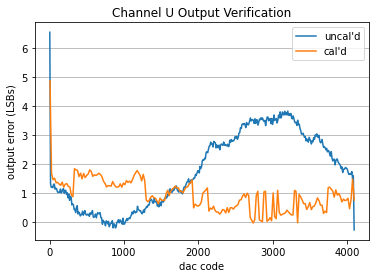

In [71]:
plt.plot(testCodes, (V_U/R_U_ohms - idealCurrent(testCodes))/LSB_A, label="uncal'd")
plt.plot(verifyCodes, (V_U_cal/R_U_ohms - idealCurrent(verifyCodes))/LSB_A, label="cal'd")
plt.xlabel('dac code')
plt.ylabel('output error (LSBs)')
plt.grid(axis='y')
plt.title('Channel U Output Verification')
plt.legend()

In [93]:
plt.plot(testCodes, (V_V/R_V_ohms - idealCurrent(testCodes))/LSB_A, label="uncal'd")
plt.plot(verifyCodes, (V_V_cal/R_V_ohms - idealCurrent(verifyCodes))/LSB_A, label="cal'd")
plt.xlabel('dac code')
plt.ylabel('output error (LSBs)')
plt.grid(axis='y')
plt.ylim(-4, 14)
plt.yticks(np.arange(-4, 14, 1))
plt.title('Channel V Output Verification')
plt.legend()

In [143]:
# Test repeatability
numTrials = 3

V = []
for i in range(numTrials):
    V.append(MeasCurrVsDacCode(testCodes, channel='V'))

In [145]:
len(V)

3

In [150]:
for trial in V:
    plt.plot(testCodes, trial/R_V_ohms - idealCurrent(testCodes))
    
plt.(testCodes, np.mean(trial)
plt.xlabel('dac code')
plt.ylabel('error (A)')

Text(0, 0.5, 'error (A)')

In [164]:
V

[5.50211212e-05,
 5.5127799e-05,
 7.79493369e-05,
 5.16895679e-05,
 5.03702986e-05,
 1.49652702e-06,
 1.1444711e-05,
 5.54975011e-05,
 5.97739957e-05,
 3.56883912e-06,
 5.39347753e-05,
 5.07380678e-05,
 1.6882087e-05,
 8.04533295e-06,
 5.05084238e-05,
 1.63402714e-05,
 4.82412162e-05,
 -2.0018877e-05,
 4.16858949e-05,
 6.19310941e-05,
 6.33651419e-05,
 6.15812855e-05,
 2.16992244e-05,
 7.58437965e-05,
 1.26428383e-05,
 3.50801884e-05,
 2.13911141e-05,
 3.64544036e-05,
 2.83089922e-05,
 7.4788442e-05,
 2.71407051e-05,
 8.65456057e-06]

In [168]:
V = []
for i in range(32):
    V.append(float(dvm.query('MEAS:VOLT:DC? 1, 1.5e-6')))

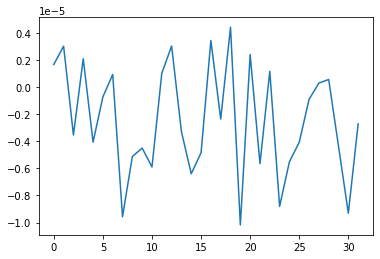

In [169]:
plt.plot(V)

In [170]:
rms(np.array(V))

4.752971072430931e-06

In [157]:
3.3/4096

0.0008056640625

In [50]:
float(serialQry(sr542, 'CURR? INST'))

-0.00141

In [63]:
codes = testCodes
channel = 'U'

serialCmd(sr542, '$CEN ON')
time.sleep(1.0)

I_mon = []
V_sense = []
for dacCode in codes:
    if(channel=='U'):
        serialCmd(sr542, f'$SUV {dacCode}, 2048')
    elif(channel=='V'):
        serialCmd(sr542, f'$SUV 2048, {dacCode}')
    else:
        print('Invalid Channel')
        break

    time.sleep(1.0)
    V = float(dvm.query('MEAS:VOLT:DC? 10, 1.5e-6')) #voltage measured across ~R_sense
    I = float(serialQry(sr542, 'CURR? INST'))
    #print(f'{dacCode}, {V}')
    I_mon.append(I)
    V_sense.append(V)    

serialCmd(sr542, '$SUV 2048, 2048')
serialCmd(sr542, '$CEN OFF')

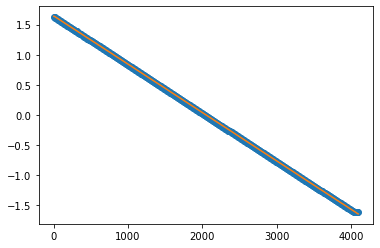

In [76]:
plt.plot(codes, -np.array(I_mon), 'o')
plt.plot(codes, np.array(V_sense)/R_W_ohms)

[0.99977609 0.01493791]


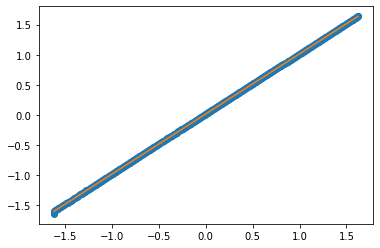

In [90]:
coeffs = np.polyfit(-np.array(I_mon), np.array(V_sense)/0.1, 1)
fit = np.poly1d(coeffs)
print(coeffs)
plt.plot(-np.array(I_mon), np.array(V_sense)/0.1, 'o')
plt.plot(-np.array(I_mon), fit(-np.array(I_mon)))